In [1]:
import h5py
import numpy as np
import tensorflow as tf
import os
import time
import glob
import Next_batch
%matplotlib inline
from matplotlib import pyplot as plt
import cv2

C:\Users\Robotmedia9\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
c_dim=3
learning_rate=1e-4
stddev=1e-3
scale=2
image_size=120
label_size=120



In [3]:
x_data=[]
y_data=[]
image_data=[]#training data load 
image_test=[]#training data load 

for i in glob.glob("./Train/*.bmp"):# load image data
    n=cv2.imread(i,cv2.IMREAD_COLOR)
    n=cv2.cvtColor(n, cv2.COLOR_BGR2RGB)# matplotlib = RGB channel , opencv = BGR channels
    image_data.append(n)
for i in range(len(image_data)):
    tmp_image=image_data[i]
    size = tmp_image.shape    # image size
    height, width = size[:2]      # height ,width
    tmp_X=cv2.resize(tmp_image,None,fx=1/scale,fy=1/scale)
#     tmp_blur=cv2.GaussianBlur(tmp_X,(3,3),0)
#     sub_X=cv2.resize(tmp_X,None,fx=scale,fy=scale,interpolation=cv2.INTER_CUBIC)
    sub_X=cv2.resize(tmp_X,(image_size, image_size),interpolation=cv2.INTER_CUBIC)
    sub_Y=cv2.resize(tmp_image,(label_size, label_size),interpolation=cv2.INTER_CUBIC)
    
    x_data.append(sub_X)
    y_data.append(sub_Y)


(120, 120, 3) (120, 120, 3)


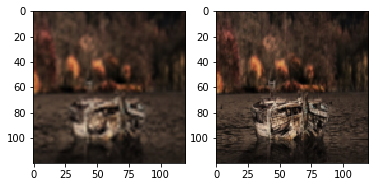

In [4]:
plt.subplot(1, 2, 1) # 1행 2열에서 1번째 열
plt.imshow(x_data[0])
print(x_data[0].shape,y_data[0].shape)
plt.subplot(1, 2, 2) # 1행 2열에서 1번째 열
plt.imshow(y_data[0])

In [ ]:
images=tf.placeholder(tf.float32,[None,image_size,image_size,c_dim],name='images')
labels=tf.placeholder(tf.float32,[None,label_size,label_size,c_dim],name='labels')
        
#parameter
#9*9
w9_1=tf.Variable(tf.random_normal([3,3,3,64],stddev=stddev), name='w9_1')
b9_1=tf.Variable(tf.zeros([64]),name='b9_1')

w9_2=tf.Variable(tf.random_normal([3,3,64,128],stddev=stddev), name='w9_2')
b9_2=tf.Variable(tf.zeros([128]),name='b9_2')

w9_3=tf.Variable(tf.random_normal([3,3,128,256],stddev=stddev), name='w9_3')
b9_3=tf.Variable(tf.zeros([64]),name='b9_3')

w9_4=tf.Variable(tf.random_normal([3,3,256,512],stddev=stddev), name='w9_4')
b9_4=tf.Variable(tf.zeros([64]),name='b9_4')

#1*1
w2=tf.Variable(tf.random_normal([1,1,512,512],stddev=stddev), name='w2')
b2=tf.Variable(tf.zeros([512]),name='b2')

#5*5
w5_1=tf.Variable(tf.random_normal([3,3,512,512],stddev=stddev), name='w5_1')        
b5_1=tf.Variable(tf.zeros([512]),name='b5_1')

w5_2=tf.Variable(tf.random_normal([3,3,512,3],stddev=stddev), name='w5_2')        
b5_2=tf.Variable(tf.zeros([3]),name='b5_2')


conv11 = tf.nn.relu(tf.nn.conv2d(images,w9_1, strides=[1,1,1,1], padding='SAME') + b9_1)
conv12= tf.nn.relu(tf.nn.conv2d(conv11,w9_2, strides=[1,1,1,1], padding='SAME') + b9_2)
conv13 = tf.nn.relu(tf.nn.conv2d(conv12,w9_3, strides=[1,1,1,1], padding='SAME') + b9_3)
conv14 = tf.nn.relu(tf.nn.conv2d(conv13,w9_4, strides=[1,1,1,1], padding='SAME') + b9_4)
conv2 = tf.nn.relu(tf.nn.conv2d(conv14, w2, strides=[1,1,1,1], padding='SAME') + b2)
conv31 = tf.nn.conv2d(conv2, w5_1, strides=[1,1,1,1], padding='SAME') + b5_1
conv3 = tf.nn.conv2d(conv31, w5_2, strides=[1,1,1,1], padding='SAME') + b5_2

In [6]:
pred=tf.squeeze(conv3)



In [7]:

loss=tf.reduce_mean(tf.square(labels-conv3))
train = tf.train.AdamOptimizer(learning_rate).minimize(loss)
# PSNR = tf.imag.psnr(labels, conv3, max_val=1.0)

In [8]:
# initialize
cost = []
saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
training_epochs = 10001
start_time=time.time()

npz_x=[]
npz_loss=[]
# npz_psnr=[]
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

# 중간에 학습한 것 불러오기
# saver.restore(sess, "./checkpoint/train_full_image_00014500.ckpt")#load training data
batch_size=32
# train my model
for epoch in range(training_epochs):
    avg_cost = 0
    avg_acc = 0
    total_batch = int(len(x_data) / batch_size)
    if(epoch%500==0 and epoch !=0):
        saver.save(sess, './checkpoint/train_full_image_%08d_padding_SAME.ckpt' % (epoch))
        print("save ! epoch : ",epoch)
    for i in range(total_batch):
        batch_images, batch_labels = next_batch(batch_size, x_data, y_data)
        
        feed_dict = {images: batch_images, labels: batch_labels}
        c, _ = sess.run([loss, train], feed_dict=feed_dict)
        avg_cost += c / total_batch
        
#         avg_psn += acc/total_batch
    print('Epoch:', '%08d' % (epoch + 1), 'Cost =','%08f' % avg_cost)    
    npz_x.append(epoch)#x 축 저장
    npz_loss.append(avg_cost) #loss 저장
#     npz_psn.append(avg_psn)
    np.savez("./checkpoint/npz/training_cost.npz",x = npz_x,y = npz_loss)
#     np.savez("./checkpoint/npz/Acc_relu_training_rate_0_5.npz",x = npz_x,y = npz_psn)
    

print('Learning Finished!')
print('Learning time : ',time.time()-start_time)

Epoch: 00000001 Cost = 7229.191683
Epoch: 00000002 Cost = 1723.320387
Epoch: 00000003 Cost = 1407.778087
Epoch: 00000004 Cost = 1288.134063
Epoch: 00000005 Cost = 1268.469122
Epoch: 00000006 Cost = 1223.988856
Epoch: 00000007 Cost = 1230.682470
Epoch: 00000008 Cost = 1181.249468
Epoch: 00000009 Cost = 1185.316908
Epoch: 00000010 Cost = 1172.428191
Epoch: 00000011 Cost = 1110.968695
Epoch: 00000012 Cost = 544.032688
Epoch: 00000013 Cost = 407.940068
Epoch: 00000014 Cost = 394.452738
Epoch: 00000015 Cost = 384.909322
Epoch: 00000016 Cost = 365.671603
Epoch: 00000017 Cost = 319.059814
Epoch: 00000018 Cost = 205.405467
Epoch: 00000019 Cost = 192.716251
Epoch: 00000020 Cost = 187.322936
Epoch: 00000021 Cost = 184.523079
Epoch: 00000022 Cost = 173.142950
Epoch: 00000023 Cost = 170.257662
Epoch: 00000024 Cost = 172.145994
Epoch: 00000025 Cost = 162.496652
Epoch: 00000026 Cost = 156.884512
Epoch: 00000027 Cost = 150.075049
Epoch: 00000028 Cost = 148.562975
Epoch: 00000029 Cost = 143.936950
Epo

Epoch: 00000248 Cost = 75.355817
Epoch: 00000249 Cost = 76.323012
Epoch: 00000250 Cost = 76.753581
Epoch: 00000251 Cost = 76.346168
Epoch: 00000252 Cost = 76.753518
Epoch: 00000253 Cost = 76.830119
Epoch: 00000254 Cost = 76.406841
Epoch: 00000255 Cost = 76.303792
Epoch: 00000256 Cost = 76.617592
Epoch: 00000257 Cost = 74.870508
Epoch: 00000258 Cost = 75.577218
Epoch: 00000259 Cost = 74.657331
Epoch: 00000260 Cost = 74.267933
Epoch: 00000261 Cost = 74.242959
Epoch: 00000262 Cost = 75.618648
Epoch: 00000263 Cost = 76.608672
Epoch: 00000264 Cost = 76.436729
Epoch: 00000265 Cost = 76.831747
Epoch: 00000266 Cost = 77.118026
Epoch: 00000267 Cost = 76.201922
Epoch: 00000268 Cost = 74.664685
Epoch: 00000269 Cost = 75.881819
Epoch: 00000270 Cost = 76.685079
Epoch: 00000271 Cost = 73.895448
Epoch: 00000272 Cost = 77.681290
Epoch: 00000273 Cost = 76.561174
Epoch: 00000274 Cost = 77.257980
Epoch: 00000275 Cost = 74.278013
Epoch: 00000276 Cost = 75.115609
Epoch: 00000277 Cost = 76.128493
Epoch: 000

Epoch: 00000497 Cost = 74.541894
Epoch: 00000498 Cost = 73.888208
Epoch: 00000499 Cost = 75.161020
Epoch: 00000500 Cost = 72.623042
save ! epoch :  500
Epoch: 00000501 Cost = 73.907569
Epoch: 00000502 Cost = 73.465605
Epoch: 00000503 Cost = 73.382902
Epoch: 00000504 Cost = 75.550638
Epoch: 00000505 Cost = 74.458664
Epoch: 00000506 Cost = 72.563805
Epoch: 00000507 Cost = 73.688290
Epoch: 00000508 Cost = 73.169327
Epoch: 00000509 Cost = 73.566197
Epoch: 00000510 Cost = 75.115157
Epoch: 00000511 Cost = 74.669630
Epoch: 00000512 Cost = 73.703017
Epoch: 00000513 Cost = 73.104336
Epoch: 00000514 Cost = 73.199153
Epoch: 00000515 Cost = 74.856891
Epoch: 00000516 Cost = 74.445449
Epoch: 00000517 Cost = 73.813095
Epoch: 00000518 Cost = 75.219400
Epoch: 00000519 Cost = 74.412180
Epoch: 00000520 Cost = 74.912350
Epoch: 00000521 Cost = 74.746227
Epoch: 00000522 Cost = 74.004922
Epoch: 00000523 Cost = 74.213910
Epoch: 00000524 Cost = 72.316473
Epoch: 00000525 Cost = 73.129816
Epoch: 00000526 Cost = 

Epoch: 00000745 Cost = 71.837277
Epoch: 00000746 Cost = 73.933772
Epoch: 00000747 Cost = 72.380762
Epoch: 00000748 Cost = 71.028369
Epoch: 00000749 Cost = 72.529021
Epoch: 00000750 Cost = 73.394137
Epoch: 00000751 Cost = 72.688617
Epoch: 00000752 Cost = 71.696374
Epoch: 00000753 Cost = 71.774858
Epoch: 00000754 Cost = 71.663079
Epoch: 00000755 Cost = 71.875915
Epoch: 00000756 Cost = 75.332648
Epoch: 00000757 Cost = 71.951359
Epoch: 00000758 Cost = 72.959121
Epoch: 00000759 Cost = 73.757001
Epoch: 00000760 Cost = 74.054980
Epoch: 00000761 Cost = 72.431291
Epoch: 00000762 Cost = 73.393136
Epoch: 00000763 Cost = 70.564441
Epoch: 00000764 Cost = 71.577474
Epoch: 00000765 Cost = 71.561037
Epoch: 00000766 Cost = 70.895611
Epoch: 00000767 Cost = 70.693499
Epoch: 00000768 Cost = 74.682124
Epoch: 00000769 Cost = 72.916349
Epoch: 00000770 Cost = 72.302740
Epoch: 00000771 Cost = 73.057524
Epoch: 00000772 Cost = 75.026451
Epoch: 00000773 Cost = 72.656907
Epoch: 00000774 Cost = 73.038838
Epoch: 000

Epoch: 00000994 Cost = 72.093704
Epoch: 00000995 Cost = 72.739380
Epoch: 00000996 Cost = 72.252085
Epoch: 00000997 Cost = 71.421254
Epoch: 00000998 Cost = 73.521695
Epoch: 00000999 Cost = 70.939354
Epoch: 00001000 Cost = 71.380338
save ! epoch :  1000
Epoch: 00001001 Cost = 73.828685
Epoch: 00001002 Cost = 73.133424
Epoch: 00001003 Cost = 70.952712
Epoch: 00001004 Cost = 72.339491
Epoch: 00001005 Cost = 72.873374
Epoch: 00001006 Cost = 72.271489
Epoch: 00001007 Cost = 73.336598
Epoch: 00001008 Cost = 73.231409
Epoch: 00001009 Cost = 72.952216
Epoch: 00001010 Cost = 71.519532
Epoch: 00001011 Cost = 73.178219
Epoch: 00001012 Cost = 73.496294
Epoch: 00001013 Cost = 73.237335
Epoch: 00001014 Cost = 68.966274
Epoch: 00001015 Cost = 72.100003
Epoch: 00001016 Cost = 74.648712
Epoch: 00001017 Cost = 73.751218
Epoch: 00001018 Cost = 73.886131
Epoch: 00001019 Cost = 72.395298
Epoch: 00001020 Cost = 74.774118
Epoch: 00001021 Cost = 72.645836
Epoch: 00001022 Cost = 71.986477
Epoch: 00001023 Cost =

Epoch: 00001242 Cost = 71.172767
Epoch: 00001243 Cost = 71.742111
Epoch: 00001244 Cost = 71.122286
Epoch: 00001245 Cost = 69.913255
Epoch: 00001246 Cost = 71.083922
Epoch: 00001247 Cost = 72.077245
Epoch: 00001248 Cost = 73.429157
Epoch: 00001249 Cost = 71.726451
Epoch: 00001250 Cost = 71.737539
Epoch: 00001251 Cost = 72.298543
Epoch: 00001252 Cost = 71.517966
Epoch: 00001253 Cost = 69.802764
Epoch: 00001254 Cost = 72.985020
Epoch: 00001255 Cost = 73.247653
Epoch: 00001256 Cost = 71.616006
Epoch: 00001257 Cost = 72.415832
Epoch: 00001258 Cost = 71.736618
Epoch: 00001259 Cost = 73.313416
Epoch: 00001260 Cost = 71.445947
Epoch: 00001261 Cost = 70.709785
Epoch: 00001262 Cost = 74.267756
Epoch: 00001263 Cost = 72.515657
Epoch: 00001264 Cost = 71.854624
Epoch: 00001265 Cost = 74.056580
Epoch: 00001266 Cost = 73.028612
Epoch: 00001267 Cost = 71.447444
Epoch: 00001268 Cost = 70.795333
Epoch: 00001269 Cost = 75.161133
Epoch: 00001270 Cost = 72.772839
Epoch: 00001271 Cost = 72.328187
Epoch: 000

Epoch: 00001491 Cost = 71.958631
Epoch: 00001492 Cost = 74.202874
Epoch: 00001493 Cost = 71.730976
Epoch: 00001494 Cost = 70.413514
Epoch: 00001495 Cost = 72.188952
Epoch: 00001496 Cost = 71.883764
Epoch: 00001497 Cost = 70.203562
Epoch: 00001498 Cost = 69.807316
Epoch: 00001499 Cost = 72.614401
Epoch: 00001500 Cost = 71.885942
save ! epoch :  1500
Epoch: 00001501 Cost = 68.632757
Epoch: 00001502 Cost = 70.235738
Epoch: 00001503 Cost = 70.249988
Epoch: 00001504 Cost = 72.189063
Epoch: 00001505 Cost = 71.335581
Epoch: 00001506 Cost = 69.255925
Epoch: 00001507 Cost = 72.342117
Epoch: 00001508 Cost = 71.597365
Epoch: 00001509 Cost = 72.962261
Epoch: 00001510 Cost = 70.511243
Epoch: 00001511 Cost = 71.435755
Epoch: 00001512 Cost = 70.976673
Epoch: 00001513 Cost = 71.689394
Epoch: 00001514 Cost = 73.941889
Epoch: 00001515 Cost = 72.269046
Epoch: 00001516 Cost = 71.692027
Epoch: 00001517 Cost = 73.003577
Epoch: 00001518 Cost = 71.748189
Epoch: 00001519 Cost = 72.296330
Epoch: 00001520 Cost =

Epoch: 00001739 Cost = 73.238490
Epoch: 00001740 Cost = 70.467182
Epoch: 00001741 Cost = 72.865838
Epoch: 00001742 Cost = 69.264007
Epoch: 00001743 Cost = 72.991618
Epoch: 00001744 Cost = 70.665586
Epoch: 00001745 Cost = 70.972865
Epoch: 00001746 Cost = 71.956164
Epoch: 00001747 Cost = 71.905784
Epoch: 00001748 Cost = 72.788423
Epoch: 00001749 Cost = 70.094660
Epoch: 00001750 Cost = 72.177421
Epoch: 00001751 Cost = 70.379643
Epoch: 00001752 Cost = 70.623184
Epoch: 00001753 Cost = 71.461130
Epoch: 00001754 Cost = 70.067688
Epoch: 00001755 Cost = 69.165950
Epoch: 00001756 Cost = 70.814162
Epoch: 00001757 Cost = 70.856578
Epoch: 00001758 Cost = 71.194515
Epoch: 00001759 Cost = 70.427602
Epoch: 00001760 Cost = 72.040061
Epoch: 00001761 Cost = 70.394352
Epoch: 00001762 Cost = 72.905275
Epoch: 00001763 Cost = 70.395438
Epoch: 00001764 Cost = 70.166653
Epoch: 00001765 Cost = 69.733638
Epoch: 00001766 Cost = 70.740661
Epoch: 00001767 Cost = 71.436256
Epoch: 00001768 Cost = 70.399515
Epoch: 000

Epoch: 00001988 Cost = 69.330486
Epoch: 00001989 Cost = 71.162291
Epoch: 00001990 Cost = 72.063821
Epoch: 00001991 Cost = 70.326298
Epoch: 00001992 Cost = 70.351700
Epoch: 00001993 Cost = 69.902065
Epoch: 00001994 Cost = 73.554412
Epoch: 00001995 Cost = 71.435279
Epoch: 00001996 Cost = 72.851964
Epoch: 00001997 Cost = 72.662860
Epoch: 00001998 Cost = 70.410424
Epoch: 00001999 Cost = 72.868254
Epoch: 00002000 Cost = 71.579873
save ! epoch :  2000
Epoch: 00002001 Cost = 69.979587
Epoch: 00002002 Cost = 71.584839
Epoch: 00002003 Cost = 72.713147
Epoch: 00002004 Cost = 69.862534
Epoch: 00002005 Cost = 70.880294
Epoch: 00002006 Cost = 71.012307
Epoch: 00002007 Cost = 70.507989
Epoch: 00002008 Cost = 69.610358
Epoch: 00002009 Cost = 69.512009
Epoch: 00002010 Cost = 75.271508
Epoch: 00002011 Cost = 71.111568
Epoch: 00002012 Cost = 71.782807
Epoch: 00002013 Cost = 71.589580
Epoch: 00002014 Cost = 69.741757
Epoch: 00002015 Cost = 71.006026
Epoch: 00002016 Cost = 70.755118
Epoch: 00002017 Cost =

Epoch: 00002236 Cost = 71.210546
Epoch: 00002237 Cost = 69.724231
Epoch: 00002238 Cost = 70.663116
Epoch: 00002239 Cost = 71.228680
Epoch: 00002240 Cost = 69.858092
Epoch: 00002241 Cost = 70.517272
Epoch: 00002242 Cost = 72.086839
Epoch: 00002243 Cost = 70.782348
Epoch: 00002244 Cost = 70.555404
Epoch: 00002245 Cost = 70.049856
Epoch: 00002246 Cost = 70.055147
Epoch: 00002247 Cost = 72.597090
Epoch: 00002248 Cost = 71.077297
Epoch: 00002249 Cost = 73.763720
Epoch: 00002250 Cost = 70.451734
Epoch: 00002251 Cost = 71.021977
Epoch: 00002252 Cost = 74.101166
Epoch: 00002253 Cost = 70.221385
Epoch: 00002254 Cost = 71.703061
Epoch: 00002255 Cost = 71.946907
Epoch: 00002256 Cost = 71.194906
Epoch: 00002257 Cost = 71.285937
Epoch: 00002258 Cost = 69.729619
Epoch: 00002259 Cost = 70.691197
Epoch: 00002260 Cost = 70.729166
Epoch: 00002261 Cost = 72.344765
Epoch: 00002262 Cost = 72.662555
Epoch: 00002263 Cost = 70.196192
Epoch: 00002264 Cost = 70.474381
Epoch: 00002265 Cost = 69.954809
Epoch: 000

Epoch: 00002485 Cost = 70.956591
Epoch: 00002486 Cost = 69.770754
Epoch: 00002487 Cost = 70.980232
Epoch: 00002488 Cost = 70.885763
Epoch: 00002489 Cost = 72.644431
Epoch: 00002490 Cost = 70.598792
Epoch: 00002491 Cost = 68.775973
Epoch: 00002492 Cost = 70.077450
Epoch: 00002493 Cost = 72.394452
Epoch: 00002494 Cost = 73.142488
Epoch: 00002495 Cost = 71.227657
Epoch: 00002496 Cost = 69.894520
Epoch: 00002497 Cost = 72.459282
Epoch: 00002498 Cost = 69.864808
Epoch: 00002499 Cost = 71.618583
Epoch: 00002500 Cost = 70.049359
save ! epoch :  2500
Epoch: 00002501 Cost = 70.941115
Epoch: 00002502 Cost = 67.485059
Epoch: 00002503 Cost = 71.522644
Epoch: 00002504 Cost = 71.199852
Epoch: 00002505 Cost = 70.096268
Epoch: 00002506 Cost = 69.552929
Epoch: 00002507 Cost = 70.593536
Epoch: 00002508 Cost = 72.203284
Epoch: 00002509 Cost = 70.488371
Epoch: 00002510 Cost = 70.982180
Epoch: 00002511 Cost = 70.445020
Epoch: 00002512 Cost = 71.272237
Epoch: 00002513 Cost = 70.711405
Epoch: 00002514 Cost =

Epoch: 00002733 Cost = 69.763852
Epoch: 00002734 Cost = 69.838472
Epoch: 00002735 Cost = 70.442969
Epoch: 00002736 Cost = 71.075566
Epoch: 00002737 Cost = 69.640590
Epoch: 00002738 Cost = 71.448422
Epoch: 00002739 Cost = 69.263083
Epoch: 00002740 Cost = 72.596246
Epoch: 00002741 Cost = 69.572487
Epoch: 00002742 Cost = 71.433737
Epoch: 00002743 Cost = 72.031926
Epoch: 00002744 Cost = 73.486162
Epoch: 00002745 Cost = 67.992637
Epoch: 00002746 Cost = 69.967077
Epoch: 00002747 Cost = 70.801891
Epoch: 00002748 Cost = 69.182102
Epoch: 00002749 Cost = 70.037048
Epoch: 00002750 Cost = 69.527628
Epoch: 00002751 Cost = 69.956626
Epoch: 00002752 Cost = 71.770714
Epoch: 00002753 Cost = 72.285144
Epoch: 00002754 Cost = 71.634973
Epoch: 00002755 Cost = 71.957510
Epoch: 00002756 Cost = 71.187502
Epoch: 00002757 Cost = 71.847358
Epoch: 00002758 Cost = 70.930680
Epoch: 00002759 Cost = 70.038400
Epoch: 00002760 Cost = 71.643047
Epoch: 00002761 Cost = 71.610298
Epoch: 00002762 Cost = 69.672123
Epoch: 000

Epoch: 00002982 Cost = 69.933665
Epoch: 00002983 Cost = 70.494151
Epoch: 00002984 Cost = 71.096495
Epoch: 00002985 Cost = 71.363682
Epoch: 00002986 Cost = 71.472331
Epoch: 00002987 Cost = 70.236896
Epoch: 00002988 Cost = 70.378646
Epoch: 00002989 Cost = 70.580932
Epoch: 00002990 Cost = 69.549656
Epoch: 00002991 Cost = 70.351490
Epoch: 00002992 Cost = 70.361474
Epoch: 00002993 Cost = 70.655856
Epoch: 00002994 Cost = 72.014136
Epoch: 00002995 Cost = 70.125479
Epoch: 00002996 Cost = 70.095120
Epoch: 00002997 Cost = 69.044580
Epoch: 00002998 Cost = 73.055741
Epoch: 00002999 Cost = 71.126906
Epoch: 00003000 Cost = 72.694218
save ! epoch :  3000
Epoch: 00003001 Cost = 70.944642
Epoch: 00003002 Cost = 71.269333
Epoch: 00003003 Cost = 69.875223
Epoch: 00003004 Cost = 70.180112
Epoch: 00003005 Cost = 69.856433
Epoch: 00003006 Cost = 70.712846
Epoch: 00003007 Cost = 69.639171
Epoch: 00003008 Cost = 71.494260
Epoch: 00003009 Cost = 70.815103
Epoch: 00003010 Cost = 73.304373
Epoch: 00003011 Cost =

Epoch: 00003230 Cost = 71.536092
Epoch: 00003231 Cost = 71.123265
Epoch: 00003232 Cost = 70.358576
Epoch: 00003233 Cost = 72.086336
Epoch: 00003234 Cost = 69.905346
Epoch: 00003235 Cost = 71.099075
Epoch: 00003236 Cost = 71.756150
Epoch: 00003237 Cost = 68.935560
Epoch: 00003238 Cost = 70.923062
Epoch: 00003239 Cost = 70.819955
Epoch: 00003240 Cost = 69.701386
Epoch: 00003241 Cost = 70.907917
Epoch: 00003242 Cost = 69.972284
Epoch: 00003243 Cost = 69.989352
Epoch: 00003244 Cost = 70.105734
Epoch: 00003245 Cost = 71.568205
Epoch: 00003246 Cost = 70.112799
Epoch: 00003247 Cost = 68.982208
Epoch: 00003248 Cost = 69.151190
Epoch: 00003249 Cost = 70.746278
Epoch: 00003250 Cost = 70.418419
Epoch: 00003251 Cost = 71.240354
Epoch: 00003252 Cost = 70.199374
Epoch: 00003253 Cost = 69.767532
Epoch: 00003254 Cost = 70.895651
Epoch: 00003255 Cost = 69.730931
Epoch: 00003256 Cost = 72.049088
Epoch: 00003257 Cost = 69.181339
Epoch: 00003258 Cost = 69.036725
Epoch: 00003259 Cost = 70.932237
Epoch: 000

Epoch: 00003479 Cost = 69.757157
Epoch: 00003480 Cost = 69.196305
Epoch: 00003481 Cost = 71.124671
Epoch: 00003482 Cost = 69.864346
Epoch: 00003483 Cost = 69.555679
Epoch: 00003484 Cost = 71.625980
Epoch: 00003485 Cost = 70.481315
Epoch: 00003486 Cost = 68.924594
Epoch: 00003487 Cost = 70.161970
Epoch: 00003488 Cost = 72.989218
Epoch: 00003489 Cost = 70.942833
Epoch: 00003490 Cost = 71.982472
Epoch: 00003491 Cost = 72.225342
Epoch: 00003492 Cost = 70.405310
Epoch: 00003493 Cost = 70.018375
Epoch: 00003494 Cost = 70.531580
Epoch: 00003495 Cost = 68.610682
Epoch: 00003496 Cost = 70.352146
Epoch: 00003497 Cost = 70.040910
Epoch: 00003498 Cost = 70.422351
Epoch: 00003499 Cost = 70.999724
Epoch: 00003500 Cost = 70.198316
save ! epoch :  3500
Epoch: 00003501 Cost = 71.835663
Epoch: 00003502 Cost = 70.784924
Epoch: 00003503 Cost = 69.205163
Epoch: 00003504 Cost = 71.587767
Epoch: 00003505 Cost = 69.630740
Epoch: 00003506 Cost = 71.868845
Epoch: 00003507 Cost = 68.757527
Epoch: 00003508 Cost =

Epoch: 00003727 Cost = 69.275981
Epoch: 00003728 Cost = 71.264916
Epoch: 00003729 Cost = 68.991369
Epoch: 00003730 Cost = 69.709212
Epoch: 00003731 Cost = 70.898431
Epoch: 00003732 Cost = 70.922227
Epoch: 00003733 Cost = 68.946410
Epoch: 00003734 Cost = 70.064028
Epoch: 00003735 Cost = 71.503045
Epoch: 00003736 Cost = 69.420218
Epoch: 00003737 Cost = 70.015888
Epoch: 00003738 Cost = 69.204074
Epoch: 00003739 Cost = 70.613242
Epoch: 00003740 Cost = 70.350060
Epoch: 00003741 Cost = 69.699028
Epoch: 00003742 Cost = 70.176530
Epoch: 00003743 Cost = 68.468179
Epoch: 00003744 Cost = 70.659652
Epoch: 00003745 Cost = 70.967976
Epoch: 00003746 Cost = 69.133487
Epoch: 00003747 Cost = 69.664827
Epoch: 00003748 Cost = 69.222608
Epoch: 00003749 Cost = 70.024342
Epoch: 00003750 Cost = 69.377374
Epoch: 00003751 Cost = 69.813358
Epoch: 00003752 Cost = 69.940967
Epoch: 00003753 Cost = 69.813023
Epoch: 00003754 Cost = 70.685771
Epoch: 00003755 Cost = 69.831859
Epoch: 00003756 Cost = 70.307897
Epoch: 000

Epoch: 00003976 Cost = 68.516042
Epoch: 00003977 Cost = 69.355089
Epoch: 00003978 Cost = 70.053556
Epoch: 00003979 Cost = 70.365651
Epoch: 00003980 Cost = 69.675843
Epoch: 00003981 Cost = 70.779812
Epoch: 00003982 Cost = 71.827147
Epoch: 00003983 Cost = 69.554559
Epoch: 00003984 Cost = 69.380886
Epoch: 00003985 Cost = 70.551987
Epoch: 00003986 Cost = 70.202506
Epoch: 00003987 Cost = 72.401267
Epoch: 00003988 Cost = 69.984354
Epoch: 00003989 Cost = 68.411401
Epoch: 00003990 Cost = 68.875734
Epoch: 00003991 Cost = 69.417524
Epoch: 00003992 Cost = 68.459548
Epoch: 00003993 Cost = 70.232416
Epoch: 00003994 Cost = 70.156079
Epoch: 00003995 Cost = 70.158259
Epoch: 00003996 Cost = 71.029730
Epoch: 00003997 Cost = 68.885202
Epoch: 00003998 Cost = 71.390066
Epoch: 00003999 Cost = 69.973753
Epoch: 00004000 Cost = 70.561096
save ! epoch :  4000
Epoch: 00004001 Cost = 70.130113
Epoch: 00004002 Cost = 70.214676
Epoch: 00004003 Cost = 70.267666
Epoch: 00004004 Cost = 70.194944
Epoch: 00004005 Cost =

Epoch: 00004224 Cost = 68.365174
Epoch: 00004225 Cost = 70.125182
Epoch: 00004226 Cost = 70.288675
Epoch: 00004227 Cost = 69.811869
Epoch: 00004228 Cost = 71.004701
Epoch: 00004229 Cost = 69.588184
Epoch: 00004230 Cost = 68.337671
Epoch: 00004231 Cost = 68.987334
Epoch: 00004232 Cost = 67.984547
Epoch: 00004233 Cost = 69.847058
Epoch: 00004234 Cost = 70.337809
Epoch: 00004235 Cost = 70.044475
Epoch: 00004236 Cost = 70.427349
Epoch: 00004237 Cost = 69.147717
Epoch: 00004238 Cost = 68.152892
Epoch: 00004239 Cost = 69.751778
Epoch: 00004240 Cost = 68.749120
Epoch: 00004241 Cost = 69.059530
Epoch: 00004242 Cost = 71.590125
Epoch: 00004243 Cost = 71.318052
Epoch: 00004244 Cost = 70.814133
Epoch: 00004245 Cost = 69.416049
Epoch: 00004246 Cost = 68.170098
Epoch: 00004247 Cost = 69.473322
Epoch: 00004248 Cost = 67.712992
Epoch: 00004249 Cost = 71.078540
Epoch: 00004250 Cost = 69.851693
Epoch: 00004251 Cost = 69.767054
Epoch: 00004252 Cost = 70.103657
Epoch: 00004253 Cost = 69.302789
Epoch: 000

Epoch: 00004473 Cost = 69.204849
Epoch: 00004474 Cost = 67.992375
Epoch: 00004475 Cost = 70.202384
Epoch: 00004476 Cost = 68.291434
Epoch: 00004477 Cost = 71.148359
Epoch: 00004478 Cost = 69.994731
Epoch: 00004479 Cost = 69.054466
Epoch: 00004480 Cost = 69.811289
Epoch: 00004481 Cost = 69.324418
Epoch: 00004482 Cost = 70.763145
Epoch: 00004483 Cost = 69.942197
Epoch: 00004484 Cost = 70.351645
Epoch: 00004485 Cost = 69.474346
Epoch: 00004486 Cost = 69.806906
Epoch: 00004487 Cost = 70.371605
Epoch: 00004488 Cost = 69.438351
Epoch: 00004489 Cost = 68.599010
Epoch: 00004490 Cost = 69.809688
Epoch: 00004491 Cost = 69.200878
Epoch: 00004492 Cost = 69.443675
Epoch: 00004493 Cost = 69.476167
Epoch: 00004494 Cost = 68.667215
Epoch: 00004495 Cost = 68.666696
Epoch: 00004496 Cost = 68.335710
Epoch: 00004497 Cost = 69.317043
Epoch: 00004498 Cost = 70.616023
Epoch: 00004499 Cost = 69.496882
Epoch: 00004500 Cost = 70.695141
save ! epoch :  4500
Epoch: 00004501 Cost = 70.453523
Epoch: 00004502 Cost =

Epoch: 00004721 Cost = 68.369612
Epoch: 00004722 Cost = 71.323075
Epoch: 00004723 Cost = 69.629226
Epoch: 00004724 Cost = 71.806005
Epoch: 00004725 Cost = 69.653930
Epoch: 00004726 Cost = 69.787411
Epoch: 00004727 Cost = 68.896173
Epoch: 00004728 Cost = 70.327872
Epoch: 00004729 Cost = 68.735806
Epoch: 00004730 Cost = 69.076519
Epoch: 00004731 Cost = 66.778347
Epoch: 00004732 Cost = 69.114282
Epoch: 00004733 Cost = 69.161063
Epoch: 00004734 Cost = 68.721587
Epoch: 00004735 Cost = 68.738673
Epoch: 00004736 Cost = 71.650269
Epoch: 00004737 Cost = 68.584233
Epoch: 00004738 Cost = 68.785463
Epoch: 00004739 Cost = 70.795511
Epoch: 00004740 Cost = 69.350919
Epoch: 00004741 Cost = 69.353506
Epoch: 00004742 Cost = 70.609802
Epoch: 00004743 Cost = 70.082815
Epoch: 00004744 Cost = 69.354330
Epoch: 00004745 Cost = 70.829361
Epoch: 00004746 Cost = 69.630346
Epoch: 00004747 Cost = 68.544778
Epoch: 00004748 Cost = 69.362854
Epoch: 00004749 Cost = 68.651406
Epoch: 00004750 Cost = 69.471251
Epoch: 000

Epoch: 00004970 Cost = 71.045071
Epoch: 00004971 Cost = 68.583266
Epoch: 00004972 Cost = 69.195189
Epoch: 00004973 Cost = 68.941699
Epoch: 00004974 Cost = 68.788346
Epoch: 00004975 Cost = 69.419801
Epoch: 00004976 Cost = 68.460971
Epoch: 00004977 Cost = 70.310423
Epoch: 00004978 Cost = 71.724272
Epoch: 00004979 Cost = 70.261399
Epoch: 00004980 Cost = 70.118306
Epoch: 00004981 Cost = 69.621126
Epoch: 00004982 Cost = 69.388750
Epoch: 00004983 Cost = 69.146215
Epoch: 00004984 Cost = 69.398743
Epoch: 00004985 Cost = 68.809457
Epoch: 00004986 Cost = 69.095334
Epoch: 00004987 Cost = 68.201395
Epoch: 00004988 Cost = 70.977323
Epoch: 00004989 Cost = 70.085406
Epoch: 00004990 Cost = 71.111094
Epoch: 00004991 Cost = 69.830821
Epoch: 00004992 Cost = 68.732570
Epoch: 00004993 Cost = 71.755354
Epoch: 00004994 Cost = 71.157904
Epoch: 00004995 Cost = 70.703807
Epoch: 00004996 Cost = 67.507768
Epoch: 00004997 Cost = 70.470905
Epoch: 00004998 Cost = 69.224765
Epoch: 00004999 Cost = 67.918554
Epoch: 000

Epoch: 00005218 Cost = 67.706335
Epoch: 00005219 Cost = 69.099011
Epoch: 00005220 Cost = 70.454995
Epoch: 00005221 Cost = 69.800609
Epoch: 00005222 Cost = 70.272422
Epoch: 00005223 Cost = 70.182864
Epoch: 00005224 Cost = 69.218490
Epoch: 00005225 Cost = 69.250872
Epoch: 00005226 Cost = 69.253570
Epoch: 00005227 Cost = 69.891049
Epoch: 00005228 Cost = 67.716706
Epoch: 00005229 Cost = 68.711847
Epoch: 00005230 Cost = 69.209063
Epoch: 00005231 Cost = 68.375610
Epoch: 00005232 Cost = 68.616088
Epoch: 00005233 Cost = 69.764957
Epoch: 00005234 Cost = 69.007745
Epoch: 00005235 Cost = 69.344835
Epoch: 00005236 Cost = 69.957715
Epoch: 00005237 Cost = 68.996492
Epoch: 00005238 Cost = 68.319441
Epoch: 00005239 Cost = 68.740227
Epoch: 00005240 Cost = 68.844347
Epoch: 00005241 Cost = 69.387944
Epoch: 00005242 Cost = 67.326320
Epoch: 00005243 Cost = 69.158854
Epoch: 00005244 Cost = 69.138286
Epoch: 00005245 Cost = 70.419125
Epoch: 00005246 Cost = 70.345472
Epoch: 00005247 Cost = 68.007492
Epoch: 000

Epoch: 00005467 Cost = 68.905581
Epoch: 00005468 Cost = 70.863759
Epoch: 00005469 Cost = 68.702051
Epoch: 00005470 Cost = 70.371948
Epoch: 00005471 Cost = 70.308635
Epoch: 00005472 Cost = 68.619407
Epoch: 00005473 Cost = 69.493127
Epoch: 00005474 Cost = 69.864378
Epoch: 00005475 Cost = 69.048930
Epoch: 00005476 Cost = 67.759758
Epoch: 00005477 Cost = 68.888975
Epoch: 00005478 Cost = 69.028258
Epoch: 00005479 Cost = 68.194266
Epoch: 00005480 Cost = 69.762111
Epoch: 00005481 Cost = 68.288438
Epoch: 00005482 Cost = 67.785688
Epoch: 00005483 Cost = 71.368672
Epoch: 00005484 Cost = 69.242358
Epoch: 00005485 Cost = 69.849735
Epoch: 00005486 Cost = 70.338882
Epoch: 00005487 Cost = 70.273010
Epoch: 00005488 Cost = 69.740985
Epoch: 00005489 Cost = 68.997759
Epoch: 00005490 Cost = 71.130790
Epoch: 00005491 Cost = 68.063422
Epoch: 00005492 Cost = 70.772528
Epoch: 00005493 Cost = 68.523045
Epoch: 00005494 Cost = 68.604336
Epoch: 00005495 Cost = 68.352135
Epoch: 00005496 Cost = 69.166708
Epoch: 000

Epoch: 00005715 Cost = 68.148292
Epoch: 00005716 Cost = 68.384955
Epoch: 00005717 Cost = 66.965950
Epoch: 00005718 Cost = 70.684700
Epoch: 00005719 Cost = 68.860324
Epoch: 00005720 Cost = 68.902305
Epoch: 00005721 Cost = 68.931874
Epoch: 00005722 Cost = 70.444790
Epoch: 00005723 Cost = 69.205829
Epoch: 00005724 Cost = 69.755193
Epoch: 00005725 Cost = 68.447734
Epoch: 00005726 Cost = 67.967226
Epoch: 00005727 Cost = 69.171587
Epoch: 00005728 Cost = 69.370341
Epoch: 00005729 Cost = 70.017555
Epoch: 00005730 Cost = 70.524243
Epoch: 00005731 Cost = 68.303310
Epoch: 00005732 Cost = 70.303135
Epoch: 00005733 Cost = 70.286303
Epoch: 00005734 Cost = 69.298874
Epoch: 00005735 Cost = 69.367705
Epoch: 00005736 Cost = 69.007990
Epoch: 00005737 Cost = 69.439336
Epoch: 00005738 Cost = 68.692297
Epoch: 00005739 Cost = 67.022554
Epoch: 00005740 Cost = 68.839922
Epoch: 00005741 Cost = 68.073706
Epoch: 00005742 Cost = 69.394408
Epoch: 00005743 Cost = 67.280112
Epoch: 00005744 Cost = 67.890942
Epoch: 000

Epoch: 00005964 Cost = 68.795516
Epoch: 00005965 Cost = 68.248478
Epoch: 00005966 Cost = 70.386880
Epoch: 00005967 Cost = 68.139121
Epoch: 00005968 Cost = 68.811201
Epoch: 00005969 Cost = 67.996675
Epoch: 00005970 Cost = 68.635029
Epoch: 00005971 Cost = 68.672852
Epoch: 00005972 Cost = 68.738815
Epoch: 00005973 Cost = 68.787849
Epoch: 00005974 Cost = 67.665864
Epoch: 00005975 Cost = 67.595685
Epoch: 00005976 Cost = 70.604160
Epoch: 00005977 Cost = 70.659150
Epoch: 00005978 Cost = 68.476629
Epoch: 00005979 Cost = 70.402949
Epoch: 00005980 Cost = 69.878185
Epoch: 00005981 Cost = 68.534746
Epoch: 00005982 Cost = 69.733429
Epoch: 00005983 Cost = 67.634780
Epoch: 00005984 Cost = 68.832324
Epoch: 00005985 Cost = 69.412725
Epoch: 00005986 Cost = 69.161325
Epoch: 00005987 Cost = 69.617617
Epoch: 00005988 Cost = 69.681803
Epoch: 00005989 Cost = 68.127344
Epoch: 00005990 Cost = 68.375140
Epoch: 00005991 Cost = 69.378593
Epoch: 00005992 Cost = 67.649277
Epoch: 00005993 Cost = 67.692258
Epoch: 000

Epoch: 00006212 Cost = 70.067419
Epoch: 00006213 Cost = 67.717540
Epoch: 00006214 Cost = 70.278402
Epoch: 00006215 Cost = 69.282473
Epoch: 00006216 Cost = 70.184127
Epoch: 00006217 Cost = 66.628877
Epoch: 00006218 Cost = 67.286179
Epoch: 00006219 Cost = 69.926149
Epoch: 00006220 Cost = 69.883882
Epoch: 00006221 Cost = 68.744707
Epoch: 00006222 Cost = 68.798568
Epoch: 00006223 Cost = 70.043307
Epoch: 00006224 Cost = 68.935646
Epoch: 00006225 Cost = 68.802365
Epoch: 00006226 Cost = 69.284471
Epoch: 00006227 Cost = 67.870513
Epoch: 00006228 Cost = 68.009490
Epoch: 00006229 Cost = 68.118414
Epoch: 00006230 Cost = 70.463478
Epoch: 00006231 Cost = 68.871206
Epoch: 00006232 Cost = 68.434737
Epoch: 00006233 Cost = 69.199793
Epoch: 00006234 Cost = 70.792967
Epoch: 00006235 Cost = 68.072697
Epoch: 00006236 Cost = 70.135811
Epoch: 00006237 Cost = 67.664218
Epoch: 00006238 Cost = 68.037171
Epoch: 00006239 Cost = 69.027520
Epoch: 00006240 Cost = 69.640090
Epoch: 00006241 Cost = 69.447939
Epoch: 000

Epoch: 00006461 Cost = 67.547954
Epoch: 00006462 Cost = 68.816659
Epoch: 00006463 Cost = 70.945464
Epoch: 00006464 Cost = 67.578529
Epoch: 00006465 Cost = 69.964076
Epoch: 00006466 Cost = 67.470559
Epoch: 00006467 Cost = 71.249834
Epoch: 00006468 Cost = 70.472230
Epoch: 00006469 Cost = 69.176240
Epoch: 00006470 Cost = 68.228387
Epoch: 00006471 Cost = 68.205491
Epoch: 00006472 Cost = 69.175121
Epoch: 00006473 Cost = 69.486928
Epoch: 00006474 Cost = 67.233026
Epoch: 00006475 Cost = 69.302000
Epoch: 00006476 Cost = 67.840510
Epoch: 00006477 Cost = 68.626148
Epoch: 00006478 Cost = 67.427586
Epoch: 00006479 Cost = 69.588561
Epoch: 00006480 Cost = 69.218637
Epoch: 00006481 Cost = 68.095277
Epoch: 00006482 Cost = 67.177225
Epoch: 00006483 Cost = 68.513363
Epoch: 00006484 Cost = 69.174946
Epoch: 00006485 Cost = 69.567621
Epoch: 00006486 Cost = 69.503069
Epoch: 00006487 Cost = 68.222896
Epoch: 00006488 Cost = 70.102000
Epoch: 00006489 Cost = 67.758960
Epoch: 00006490 Cost = 68.571052
Epoch: 000

Epoch: 00006709 Cost = 68.074675
Epoch: 00006710 Cost = 65.960332
Epoch: 00006711 Cost = 67.380504
Epoch: 00006712 Cost = 68.375342
Epoch: 00006713 Cost = 69.686947
Epoch: 00006714 Cost = 68.159040
Epoch: 00006715 Cost = 67.424392
Epoch: 00006716 Cost = 67.793557
Epoch: 00006717 Cost = 69.104167
Epoch: 00006718 Cost = 69.345050
Epoch: 00006719 Cost = 69.179045
Epoch: 00006720 Cost = 69.921247
Epoch: 00006721 Cost = 68.597341
Epoch: 00006722 Cost = 67.747371
Epoch: 00006723 Cost = 67.311620
Epoch: 00006724 Cost = 65.934112
Epoch: 00006725 Cost = 68.309283
Epoch: 00006726 Cost = 70.794023
Epoch: 00006727 Cost = 68.400561
Epoch: 00006728 Cost = 69.279000
Epoch: 00006729 Cost = 69.854318
Epoch: 00006730 Cost = 68.163744
Epoch: 00006731 Cost = 69.137747
Epoch: 00006732 Cost = 68.524146
Epoch: 00006733 Cost = 67.766290
Epoch: 00006734 Cost = 69.132796
Epoch: 00006735 Cost = 68.823394
Epoch: 00006736 Cost = 68.449834
Epoch: 00006737 Cost = 69.516904
Epoch: 00006738 Cost = 67.977145
Epoch: 000

Epoch: 00006958 Cost = 70.037697
Epoch: 00006959 Cost = 68.637049
Epoch: 00006960 Cost = 70.228179
Epoch: 00006961 Cost = 71.425005
Epoch: 00006962 Cost = 68.130197
Epoch: 00006963 Cost = 68.514458
Epoch: 00006964 Cost = 68.953808
Epoch: 00006965 Cost = 69.148588
Epoch: 00006966 Cost = 69.774624
Epoch: 00006967 Cost = 68.235207
Epoch: 00006968 Cost = 66.749563
Epoch: 00006969 Cost = 69.799694
Epoch: 00006970 Cost = 67.008289
Epoch: 00006971 Cost = 68.231334
Epoch: 00006972 Cost = 70.177931
Epoch: 00006973 Cost = 68.016211
Epoch: 00006974 Cost = 68.051240
Epoch: 00006975 Cost = 68.237975
Epoch: 00006976 Cost = 67.885004
Epoch: 00006977 Cost = 67.685692
Epoch: 00006978 Cost = 68.593452
Epoch: 00006979 Cost = 68.863341
Epoch: 00006980 Cost = 68.315586
Epoch: 00006981 Cost = 67.527387
Epoch: 00006982 Cost = 68.054511
Epoch: 00006983 Cost = 70.252008
Epoch: 00006984 Cost = 70.137841
Epoch: 00006985 Cost = 67.313202
Epoch: 00006986 Cost = 68.308981
Epoch: 00006987 Cost = 68.677083
Epoch: 000

Epoch: 00007206 Cost = 68.150094
Epoch: 00007207 Cost = 67.916050
Epoch: 00007208 Cost = 68.042676
Epoch: 00007209 Cost = 68.623861
Epoch: 00007210 Cost = 68.727320
Epoch: 00007211 Cost = 68.254021
Epoch: 00007212 Cost = 69.530498
Epoch: 00007213 Cost = 66.874308
Epoch: 00007214 Cost = 68.565706
Epoch: 00007215 Cost = 69.832966
Epoch: 00007216 Cost = 69.587645
Epoch: 00007217 Cost = 66.564193
Epoch: 00007218 Cost = 68.070649
Epoch: 00007219 Cost = 67.523886
Epoch: 00007220 Cost = 68.710734
Epoch: 00007221 Cost = 67.702546
Epoch: 00007222 Cost = 67.401207
Epoch: 00007223 Cost = 67.846313
Epoch: 00007224 Cost = 70.515827
Epoch: 00007225 Cost = 67.713299
Epoch: 00007226 Cost = 69.428336
Epoch: 00007227 Cost = 68.049798
Epoch: 00007228 Cost = 68.862739
Epoch: 00007229 Cost = 68.053473
Epoch: 00007230 Cost = 67.321813
Epoch: 00007231 Cost = 69.310571
Epoch: 00007232 Cost = 67.968499
Epoch: 00007233 Cost = 68.541725
Epoch: 00007234 Cost = 69.493043
Epoch: 00007235 Cost = 67.998108
Epoch: 000

Epoch: 00007455 Cost = 67.451319
Epoch: 00007456 Cost = 67.318759
Epoch: 00007457 Cost = 70.134960
Epoch: 00007458 Cost = 69.048882
Epoch: 00007459 Cost = 68.415173
Epoch: 00007460 Cost = 68.780996
Epoch: 00007461 Cost = 66.731258
Epoch: 00007462 Cost = 68.497525
Epoch: 00007463 Cost = 69.500716
Epoch: 00007464 Cost = 68.603815
Epoch: 00007465 Cost = 67.783699
Epoch: 00007466 Cost = 68.637164
Epoch: 00007467 Cost = 67.314804
Epoch: 00007468 Cost = 68.435529
Epoch: 00007469 Cost = 66.625271
Epoch: 00007470 Cost = 70.493948
Epoch: 00007471 Cost = 68.308260
Epoch: 00007472 Cost = 69.268268
Epoch: 00007473 Cost = 67.302626
Epoch: 00007474 Cost = 67.733347
Epoch: 00007475 Cost = 68.075154
Epoch: 00007476 Cost = 68.421109
Epoch: 00007477 Cost = 69.384846
Epoch: 00007478 Cost = 68.194601
Epoch: 00007479 Cost = 67.258977
Epoch: 00007480 Cost = 69.081239
Epoch: 00007481 Cost = 70.917521
Epoch: 00007482 Cost = 67.405561
Epoch: 00007483 Cost = 68.406507
Epoch: 00007484 Cost = 67.977380
Epoch: 000

Epoch: 00007703 Cost = 68.365464
Epoch: 00007704 Cost = 68.585383
Epoch: 00007705 Cost = 68.686188
Epoch: 00007706 Cost = 68.784228
Epoch: 00007707 Cost = 67.004448
Epoch: 00007708 Cost = 67.977478
Epoch: 00007709 Cost = 66.214780
Epoch: 00007710 Cost = 68.540891
Epoch: 00007711 Cost = 67.044939
Epoch: 00007712 Cost = 67.857995
Epoch: 00007713 Cost = 67.359720
Epoch: 00007714 Cost = 69.623501
Epoch: 00007715 Cost = 68.645343
Epoch: 00007716 Cost = 68.596259
Epoch: 00007717 Cost = 70.066777
Epoch: 00007718 Cost = 67.946436
Epoch: 00007719 Cost = 65.797507
Epoch: 00007720 Cost = 68.382170
Epoch: 00007721 Cost = 67.227162
Epoch: 00007722 Cost = 67.344059
Epoch: 00007723 Cost = 67.425369
Epoch: 00007724 Cost = 67.576952
Epoch: 00007725 Cost = 68.360814
Epoch: 00007726 Cost = 67.126917
Epoch: 00007727 Cost = 69.084560
Epoch: 00007728 Cost = 69.620639
Epoch: 00007729 Cost = 68.848293
Epoch: 00007730 Cost = 69.984185
Epoch: 00007731 Cost = 68.106970
Epoch: 00007732 Cost = 66.421732
Epoch: 000

Epoch: 00007952 Cost = 67.364364
Epoch: 00007953 Cost = 67.540247
Epoch: 00007954 Cost = 67.913048
Epoch: 00007955 Cost = 68.485974
Epoch: 00007956 Cost = 67.993643
Epoch: 00007957 Cost = 69.381158
Epoch: 00007958 Cost = 68.260770
Epoch: 00007959 Cost = 67.428708
Epoch: 00007960 Cost = 69.210513
Epoch: 00007961 Cost = 66.651301
Epoch: 00007962 Cost = 65.542743
Epoch: 00007963 Cost = 69.363359
Epoch: 00007964 Cost = 68.468841
Epoch: 00007965 Cost = 68.009824
Epoch: 00007966 Cost = 67.832529
Epoch: 00007967 Cost = 66.764550
Epoch: 00007968 Cost = 67.631852
Epoch: 00007969 Cost = 69.006898
Epoch: 00007970 Cost = 69.989938
Epoch: 00007971 Cost = 69.833522
Epoch: 00007972 Cost = 68.265241
Epoch: 00007973 Cost = 69.642275
Epoch: 00007974 Cost = 69.135861
Epoch: 00007975 Cost = 69.000911
Epoch: 00007976 Cost = 66.315234
Epoch: 00007977 Cost = 69.006725
Epoch: 00007978 Cost = 67.464101
Epoch: 00007979 Cost = 70.651695
Epoch: 00007980 Cost = 66.649038
Epoch: 00007981 Cost = 68.339604
Epoch: 000

Epoch: 00008200 Cost = 68.017300
Epoch: 00008201 Cost = 68.257652
Epoch: 00008202 Cost = 68.994838
Epoch: 00008203 Cost = 67.518077
Epoch: 00008204 Cost = 67.726849
Epoch: 00008205 Cost = 67.195073
Epoch: 00008206 Cost = 67.908273
Epoch: 00008207 Cost = 67.430720
Epoch: 00008208 Cost = 68.002698
Epoch: 00008209 Cost = 66.915642
Epoch: 00008210 Cost = 67.587592
Epoch: 00008211 Cost = 68.306632
Epoch: 00008212 Cost = 67.856015
Epoch: 00008213 Cost = 69.209383
Epoch: 00008214 Cost = 68.057811
Epoch: 00008215 Cost = 69.091484
Epoch: 00008216 Cost = 68.101775
Epoch: 00008217 Cost = 66.860364
Epoch: 00008218 Cost = 67.588931
Epoch: 00008219 Cost = 68.445121
Epoch: 00008220 Cost = 67.269489
Epoch: 00008221 Cost = 70.099393
Epoch: 00008222 Cost = 68.298753
Epoch: 00008223 Cost = 67.278056
Epoch: 00008224 Cost = 68.722928
Epoch: 00008225 Cost = 68.578921
Epoch: 00008226 Cost = 68.356079
Epoch: 00008227 Cost = 69.403581
Epoch: 00008228 Cost = 67.533337
Epoch: 00008229 Cost = 68.323145
Epoch: 000

Epoch: 00008449 Cost = 67.068641
Epoch: 00008450 Cost = 68.820750
Epoch: 00008451 Cost = 68.306416
Epoch: 00008452 Cost = 69.657485
Epoch: 00008453 Cost = 68.075341
Epoch: 00008454 Cost = 67.207611
Epoch: 00008455 Cost = 68.873674
Epoch: 00008456 Cost = 66.895662
Epoch: 00008457 Cost = 67.726105
Epoch: 00008458 Cost = 69.891805
Epoch: 00008459 Cost = 67.714585
Epoch: 00008460 Cost = 68.281115
Epoch: 00008461 Cost = 70.691186
Epoch: 00008462 Cost = 68.825020
Epoch: 00008463 Cost = 67.870405
Epoch: 00008464 Cost = 69.339529
Epoch: 00008465 Cost = 68.168219
Epoch: 00008466 Cost = 68.936441
Epoch: 00008467 Cost = 68.287316
Epoch: 00008468 Cost = 68.639413
Epoch: 00008469 Cost = 68.796173
Epoch: 00008470 Cost = 68.266152
Epoch: 00008471 Cost = 69.050465
Epoch: 00008472 Cost = 69.056073
Epoch: 00008473 Cost = 68.464627
Epoch: 00008474 Cost = 69.145362
Epoch: 00008475 Cost = 69.065817
Epoch: 00008476 Cost = 68.282976
Epoch: 00008477 Cost = 67.862995
Epoch: 00008478 Cost = 68.848981
Epoch: 000

Epoch: 00008697 Cost = 67.209299
Epoch: 00008698 Cost = 67.994916
Epoch: 00008699 Cost = 69.423175
Epoch: 00008700 Cost = 68.813399
Epoch: 00008701 Cost = 68.759173
Epoch: 00008702 Cost = 68.635688
Epoch: 00008703 Cost = 68.670884
Epoch: 00008704 Cost = 67.886064
Epoch: 00008705 Cost = 69.308011
Epoch: 00008706 Cost = 69.562181
Epoch: 00008707 Cost = 68.096214
Epoch: 00008708 Cost = 67.597606
Epoch: 00008709 Cost = 67.960941
Epoch: 00008710 Cost = 67.266791
Epoch: 00008711 Cost = 67.925245
Epoch: 00008712 Cost = 67.761331
Epoch: 00008713 Cost = 67.252606
Epoch: 00008714 Cost = 67.736133
Epoch: 00008715 Cost = 68.543168
Epoch: 00008716 Cost = 67.896518
Epoch: 00008717 Cost = 67.825331
Epoch: 00008718 Cost = 69.134532
Epoch: 00008719 Cost = 67.333401
Epoch: 00008720 Cost = 68.813119
Epoch: 00008721 Cost = 69.202529
Epoch: 00008722 Cost = 68.779683
Epoch: 00008723 Cost = 68.470391
Epoch: 00008724 Cost = 66.350093
Epoch: 00008725 Cost = 66.235400
Epoch: 00008726 Cost = 69.219036
Epoch: 000

Epoch: 00008946 Cost = 66.814633
Epoch: 00008947 Cost = 67.695446
Epoch: 00008948 Cost = 67.641829
Epoch: 00008949 Cost = 67.629186
Epoch: 00008950 Cost = 66.642941
Epoch: 00008951 Cost = 68.841714
Epoch: 00008952 Cost = 67.944435
Epoch: 00008953 Cost = 67.823845
Epoch: 00008954 Cost = 66.777571
Epoch: 00008955 Cost = 68.096800
Epoch: 00008956 Cost = 67.589168
Epoch: 00008957 Cost = 67.310788
Epoch: 00008958 Cost = 67.497708
Epoch: 00008959 Cost = 68.421570
Epoch: 00008960 Cost = 66.647267
Epoch: 00008961 Cost = 69.011424
Epoch: 00008962 Cost = 67.105063
Epoch: 00008963 Cost = 67.603586
Epoch: 00008964 Cost = 67.221218
Epoch: 00008965 Cost = 67.951989
Epoch: 00008966 Cost = 68.023926
Epoch: 00008967 Cost = 68.346167
Epoch: 00008968 Cost = 67.892079
Epoch: 00008969 Cost = 68.758865
Epoch: 00008970 Cost = 69.173070
Epoch: 00008971 Cost = 68.628014
Epoch: 00008972 Cost = 69.900702
Epoch: 00008973 Cost = 68.287794
Epoch: 00008974 Cost = 69.148740
Epoch: 00008975 Cost = 68.467411
Epoch: 000

Epoch: 00009194 Cost = 66.985004
Epoch: 00009195 Cost = 67.285920
Epoch: 00009196 Cost = 66.705133
Epoch: 00009197 Cost = 68.353115
Epoch: 00009198 Cost = 69.006838
Epoch: 00009199 Cost = 66.789120
Epoch: 00009200 Cost = 69.912040
Epoch: 00009201 Cost = 67.556265
Epoch: 00009202 Cost = 68.382379
Epoch: 00009203 Cost = 67.589566
Epoch: 00009204 Cost = 67.303010
Epoch: 00009205 Cost = 70.641527
Epoch: 00009206 Cost = 67.269481
Epoch: 00009207 Cost = 69.182919
Epoch: 00009208 Cost = 66.264284
Epoch: 00009209 Cost = 68.934483
Epoch: 00009210 Cost = 67.666049
Epoch: 00009211 Cost = 68.367488
Epoch: 00009212 Cost = 67.205448
Epoch: 00009213 Cost = 68.668016
Epoch: 00009214 Cost = 67.733270
Epoch: 00009215 Cost = 66.931070
Epoch: 00009216 Cost = 67.525412
Epoch: 00009217 Cost = 68.056509
Epoch: 00009218 Cost = 67.815328
Epoch: 00009219 Cost = 70.515938
Epoch: 00009220 Cost = 68.006685
Epoch: 00009221 Cost = 68.931261
Epoch: 00009222 Cost = 68.165590
Epoch: 00009223 Cost = 68.867372
Epoch: 000

Epoch: 00009443 Cost = 66.996928
Epoch: 00009444 Cost = 66.961024
Epoch: 00009445 Cost = 68.814131
Epoch: 00009446 Cost = 67.174389
Epoch: 00009447 Cost = 68.180825
Epoch: 00009448 Cost = 67.105111
Epoch: 00009449 Cost = 67.302467
Epoch: 00009450 Cost = 67.956698
Epoch: 00009451 Cost = 67.290481
Epoch: 00009452 Cost = 69.108235
Epoch: 00009453 Cost = 67.855442
Epoch: 00009454 Cost = 67.753914
Epoch: 00009455 Cost = 68.627660
Epoch: 00009456 Cost = 67.972391
Epoch: 00009457 Cost = 68.016768
Epoch: 00009458 Cost = 68.214540
Epoch: 00009459 Cost = 68.919380
Epoch: 00009460 Cost = 69.839081
Epoch: 00009461 Cost = 68.044929
Epoch: 00009462 Cost = 68.826837
Epoch: 00009463 Cost = 66.986822
Epoch: 00009464 Cost = 66.292812
Epoch: 00009465 Cost = 66.927753
Epoch: 00009466 Cost = 68.803970
Epoch: 00009467 Cost = 66.783269
Epoch: 00009468 Cost = 69.369830
Epoch: 00009469 Cost = 67.228075
Epoch: 00009470 Cost = 68.383787
Epoch: 00009471 Cost = 67.346830
Epoch: 00009472 Cost = 69.040142
Epoch: 000

Epoch: 00009691 Cost = 66.388309
Epoch: 00009692 Cost = 67.940481
Epoch: 00009693 Cost = 69.445761
Epoch: 00009694 Cost = 68.888939
Epoch: 00009695 Cost = 68.575286
Epoch: 00009696 Cost = 68.654745
Epoch: 00009697 Cost = 68.355700
Epoch: 00009698 Cost = 68.499865
Epoch: 00009699 Cost = 69.224762
Epoch: 00009700 Cost = 67.642012
Epoch: 00009701 Cost = 69.029676
Epoch: 00009702 Cost = 67.044711
Epoch: 00009703 Cost = 67.115132
Epoch: 00009704 Cost = 69.729382
Epoch: 00009705 Cost = 67.367792
Epoch: 00009706 Cost = 67.798344
Epoch: 00009707 Cost = 67.489414
Epoch: 00009708 Cost = 69.311762
Epoch: 00009709 Cost = 68.049390
Epoch: 00009710 Cost = 67.955283
Epoch: 00009711 Cost = 68.477753
Epoch: 00009712 Cost = 68.090952
Epoch: 00009713 Cost = 67.665833
Epoch: 00009714 Cost = 68.655147
Epoch: 00009715 Cost = 66.565850
Epoch: 00009716 Cost = 68.459908
Epoch: 00009717 Cost = 69.173753
Epoch: 00009718 Cost = 68.434928
Epoch: 00009719 Cost = 64.760225
Epoch: 00009720 Cost = 68.783356
Epoch: 000

Epoch: 00009940 Cost = 70.494214
Epoch: 00009941 Cost = 68.246631
Epoch: 00009942 Cost = 68.432631
Epoch: 00009943 Cost = 67.576556
Epoch: 00009944 Cost = 67.154341
Epoch: 00009945 Cost = 68.217103
Epoch: 00009946 Cost = 67.602920
Epoch: 00009947 Cost = 68.588868
Epoch: 00009948 Cost = 67.851542
Epoch: 00009949 Cost = 67.959063
Epoch: 00009950 Cost = 68.134149
Epoch: 00009951 Cost = 65.927468
Epoch: 00009952 Cost = 67.587882
Epoch: 00009953 Cost = 70.148010
Epoch: 00009954 Cost = 68.119043
Epoch: 00009955 Cost = 66.676783
Epoch: 00009956 Cost = 68.398363
Epoch: 00009957 Cost = 68.522251
Epoch: 00009958 Cost = 67.316727
Epoch: 00009959 Cost = 68.859724
Epoch: 00009960 Cost = 67.204633
Epoch: 00009961 Cost = 68.685896
Epoch: 00009962 Cost = 67.972917
Epoch: 00009963 Cost = 67.310331
Epoch: 00009964 Cost = 70.763272
Epoch: 00009965 Cost = 66.204762
Epoch: 00009966 Cost = 68.530386
Epoch: 00009967 Cost = 68.827478
Epoch: 00009968 Cost = 69.084907
Epoch: 00009969 Cost = 67.406399
Epoch: 000

In [48]:
c_dim=3
learning_rate=1e-4
stddev=1e-3
scale=2
image_size=120
label_size=120

In [49]:
#####################################################test##########################################################################

x_test=[]
y_test=[]
image_test=[]
for i in glob.glob("./Test/Set5/*.bmp"):# load image data
    n=cv2.imread(i,cv2.IMREAD_COLOR)
    n=cv2.cvtColor(n, cv2.COLOR_BGR2RGB)# matplotlib = RGB channel , opencv = BGR channels
    image_test.append(n)
for i in range(len(image_test)):
    tmp_image=image_test[i]
    size = tmp_image.shape    # image size
    height, width = size[:2]      # height ,width
    tmp_X=cv2.resize(tmp_image,None,fx=1/scale,fy=1/scale)
#     tmp_blur=cv2.GaussianBlur(tmp_X,(3,3),0)
#     sub_X=cv2.resize(tmp_X,None,fx=scale,fy=scale,interpolation=cv2.INTER_CUBIC)
    sub_X=cv2.resize(tmp_X,(image_size, image_size),interpolation=cv2.INTER_CUBIC)
    sub_Y=cv2.resize(tmp_image,(label_size, label_size),interpolation=cv2.INTER_CUBIC)
    
    
    x_test.append(sub_X)
    y_test.append(sub_Y)

In [50]:
#####################################################test##########################################################################

sess=tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(sess, "./checkpoint/train_full_image_00010000_padding_SAME.ckpt")#load training data
# x_axis=[]#x 축
# acc_test=[]#accuracy
# precision_test=[]#precision
# recall_test=[]#recall
# f1_test=[]#f1
batch_size=1
length=int(len(x_test) / batch_size)
avg_acc=0
result=[]
for i in range(length):
    batch_images = x_test[i*batch_size : (i+1)*batch_size]
    feed_dict={images:batch_images}
    tmp = sess.run(conv3,feed_dict=feed_dict)
    result.append(tmp)
print("testing complete")
result=np.asarray(result)

INFO:tensorflow:Restoring parameters from ./checkpoint/train_full_image_00010000_padding_SAME.ckpt
testing complete


In [51]:
print(result.shape)
result=np.squeeze(result)
print(result.shape)
result = np.clip(result, 0, 255).astype(np.uint8)#소수점 제거

(5, 1, 120, 120, 3)
(5, 120, 120, 3)


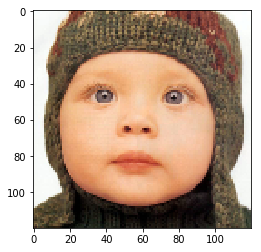

In [52]:
# plt.subplot(1,2,1)
plt.imshow(x_test[0])
# plt.subplot(1,2,2)


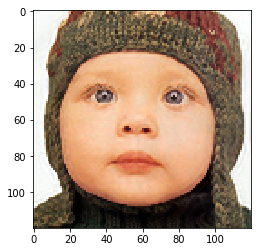

In [53]:
plt.imshow(result[0])


In [55]:
import numpy
import math

def psnr(img1, img2):
    mse = numpy.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [58]:
print("{0:.2f}".format(psnr(x_test[0],result[0])))

33.86
